<a href="https://colab.research.google.com/github/Original-2/Equinox_Examples/blob/main/Convolutional_autoencoder_for_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [1]:
!pip install equinox
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import equinox as eqx
from tensorflow.keras.datasets import mnist
import optax
from tqdm import trange

def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = jnp.resize(jnp.array(array), (len(array),1,28,28,))
    return array


def noise(array, key):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * jax.random.normal(key, array.shape)

    return jnp.clip(noisy_array, 0.0, 1.0)


def display(array1, array2, key):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = jax.random.randint(key, (10,), 0, len(array1))
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

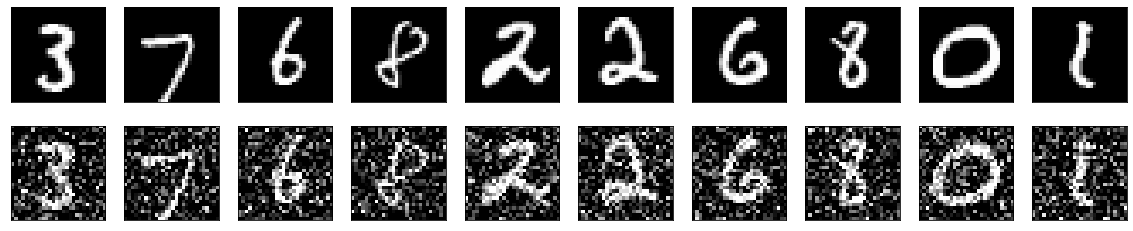

In [3]:
key = jax.random.PRNGKey(1234)
key, noise1, noise2, display1 = jax.random.split(key, 4)

# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = jnp.array(preprocess(train_data))
test_data = jnp.array(preprocess(test_data))

# Create a copy of the data with added noise
noisy_train_data = jnp.array(noise(train_data, noise1))
noisy_test_data = jnp.array(noise(test_data, noise2))

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data, display1)

del noise1, noise2, display1

## Build the autoencoder


In [4]:
class autoencoder(eqx.Module):
    encoder_conv: list
    decoder_transpose_conv: list
    decoder_conv: eqx.nn.Conv2d

    def __init__(
        self,
        *,
        key,
    ):
        key1, key2, key3 = jax.random.split(key, 3)

        self.encoder_conv = [eqx.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, key=key1),
                      eqx.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, key=key2)]

        self.decoder_transpose_conv = [eqx.nn.ConvTranspose(2, in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0, key=key1),
                      eqx.nn.ConvTranspose(2, in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0, key=key1)]

        self.decoder_conv = eqx.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1, key=key1)


    def __call__(self, x):
        x = eqx.nn.MaxPool2D((2,2),2)(jax.nn.relu(self.encoder_conv[0](x)))
        x = eqx.nn.MaxPool2D((2,2),2)(jax.nn.relu(self.encoder_conv[1](x)))

        x = jax.nn.relu(self.decoder_transpose_conv[0](x))
        x = jax.nn.relu(self.decoder_transpose_conv[1](x))

        x = jax.nn.sigmoid(self.decoder_conv(x))

        return x

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [5]:
def main(
    x_train,
    y_train,
    x_test,
    y_test,
    key,
    batch_size=128,
    learning_rate=0.001,
    steps=60000//128,
    val_steps=10000//128,
    epochs=1#50
):
    key, temp = jax.random.split(key, 2)
    model = autoencoder(key=temp)

    @eqx.filter_value_and_grad
    def compute_loss(model, x, y):
        pred_y = jax.vmap(model)(x)
        # Trains with respect to binary cross-entropy
        return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

    @eqx.filter_jit
    def make_step(model, x, y, opt_state):
        loss, grads = compute_loss(model, x, y)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    def compute_metrics(model, x, y):
        predy = jax.vmap(model)(x)    
        losses = -jnp.mean(y * jnp.log(predy) + (1 - y) * jnp.log(1 - predy))
        return losses

    optim = optax.adam(learning_rate)
    opt_state = optim.init(model)

    for epoch in range(epochs):
        bar = trange(steps)
        for i in bar:
            bar.set_description(f"epoch {epoch+1} of {epochs}")
            start = i*batch_size
            stop = i*batch_size+batch_size

            loss, model, opt_state = make_step(model, x_train[start:stop], y_train[start:stop], opt_state)
            loss = loss.item()
            bar.set_postfix(loss=loss)

        ### compute metrics ###

        metrics = []

        for i in range(val_steps):
          start = i*batch_size
          stop = i*batch_size+batch_size

          l = compute_metrics(model, x_test[start:stop], y_test[start:stop])

          metrics.append(l)

        print("loss: " + str(jnp.mean(jnp.array(metrics))))
    return model

In [6]:
key, train = jax.random.split(key, 2)

model = main(x_train=train_data,
    y_train=train_data,
    x_test=test_data,
    y_test=test_data,
    key=train,
    epochs=10)

del train

epoch 1 of 10: 100%|██████████| 468/468 [00:15<00:00, 30.67it/s, loss=0.0765]


loss: 0.07758693


epoch 2 of 10: 100%|██████████| 468/468 [00:09<00:00, 50.00it/s, loss=0.0724]


loss: 0.072731204


epoch 3 of 10: 100%|██████████| 468/468 [00:09<00:00, 50.14it/s, loss=0.071]


loss: 0.070968725


epoch 4 of 10: 100%|██████████| 468/468 [00:09<00:00, 49.74it/s, loss=0.0695]


loss: 0.06999859


epoch 5 of 10: 100%|██████████| 468/468 [00:09<00:00, 50.52it/s, loss=0.0686]


loss: 0.06905207


epoch 6 of 10: 100%|██████████| 468/468 [00:09<00:00, 47.90it/s, loss=0.068]


loss: 0.06832803


epoch 7 of 10: 100%|██████████| 468/468 [00:09<00:00, 49.46it/s, loss=0.0675]


loss: 0.067836575


epoch 8 of 10: 100%|██████████| 468/468 [00:09<00:00, 49.45it/s, loss=0.0671]


loss: 0.06748144


epoch 9 of 10: 100%|██████████| 468/468 [00:09<00:00, 50.62it/s, loss=0.0668]


loss: 0.06721795


epoch 10 of 10: 100%|██████████| 468/468 [00:09<00:00, 50.64it/s, loss=0.0665]


loss: 0.066950165


Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

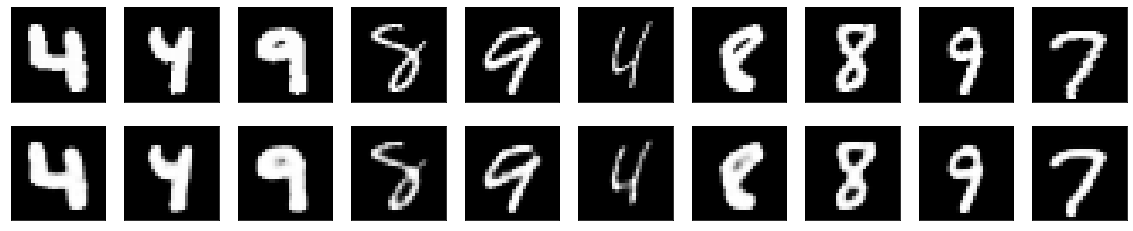

In [7]:
key, displaykey = jax.random.split(key, 2)

predictions = jnp.array(jax.vmap(model)(test_data))
display(test_data, predictions, displaykey)

del displaykey

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [8]:
key, train = jax.random.split(key, 2)

model = main(x_train=noisy_train_data,
    y_train=train_data,
    x_test=noisy_test_data,
    y_test=test_data,
    key=train,
    epochs=20)

del train

epoch 1 of 20: 100%|██████████| 468/468 [00:09<00:00, 48.83it/s, loss=0.107]


loss: 0.11039352


epoch 2 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.17it/s, loss=0.0994]


loss: 0.101649776


epoch 3 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.46it/s, loss=0.0966]


loss: 0.09887238


epoch 4 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.36it/s, loss=0.0948]


loss: 0.0970087


epoch 5 of 20: 100%|██████████| 468/468 [00:11<00:00, 39.41it/s, loss=0.0937]


loss: 0.095861025


epoch 6 of 20: 100%|██████████| 468/468 [00:09<00:00, 48.95it/s, loss=0.093]


loss: 0.09508814


epoch 7 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.32it/s, loss=0.0924]


loss: 0.09453367


epoch 8 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.49it/s, loss=0.092]


loss: 0.094064176


epoch 9 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.96it/s, loss=0.0915]


loss: 0.093682915


epoch 10 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.41it/s, loss=0.0911]


loss: 0.09331011


epoch 11 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.60it/s, loss=0.0908]


loss: 0.09301062


epoch 12 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.89it/s, loss=0.0905]


loss: 0.09274305


epoch 13 of 20: 100%|██████████| 468/468 [00:09<00:00, 47.46it/s, loss=0.0903]


loss: 0.09249201


epoch 14 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.57it/s, loss=0.09]


loss: 0.09224365


epoch 15 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.84it/s, loss=0.0898]


loss: 0.09201979


epoch 16 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.78it/s, loss=0.0896]


loss: 0.091826305


epoch 17 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.84it/s, loss=0.0894]


loss: 0.091636844


epoch 18 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.01it/s, loss=0.0892]


loss: 0.09146035


epoch 19 of 20: 100%|██████████| 468/468 [00:09<00:00, 49.32it/s, loss=0.0891]


loss: 0.09129881


epoch 20 of 20: 100%|██████████| 468/468 [00:09<00:00, 50.31it/s, loss=0.0889]


loss: 0.09115345


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images, however small details are lost.

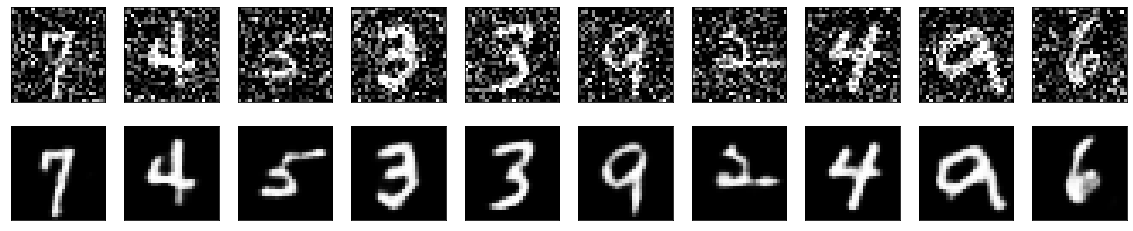

In [11]:
key, displaykey = jax.random.split(key, 2)

predictions = jnp.array(jax.vmap(model)(noisy_test_data))
display(noisy_test_data, predictions, displaykey)

del displaykey